Calculate functionals with symbolics 
create kernel 

Create points 

construnct distance tnsors 


apply kernel to a distance tensor 

assemble RHS and matrices 

Assemble DAE 

Solve with diffeq.jl or custom code 





In [1]:
using Revise
using CairoMakie
using Symbolics
using Latexify
using DifferentialEquations
using Sundials
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")

In [2]:
@variables ϵ r x₁ x₂ t;
const nu = 1.0
#ϕ = 1//945 * ((ϵ*r)^5 +15*(ϵ*r)^3 + 105*(ϵ*r)^2 + 945*(ϵ*r)+ 945)* exp(-ϵ*r)
ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#display(ϕ)  
Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = expand_derivatives(Differential(x₁)(exprs))
∂₂(exprs) = expand_derivatives(Differential(x₂)(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0 ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
ΔΦ_div= Δ.([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)); ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_curl = ([-∂₁(∂₁(ϕ)) -∂₁(∂₂(ϕ)); -∂₁(∂₂(ϕ)) -∂₂(∂₂(ϕ))])
Φ = [ϕ 0.0 0.0; 0.0 ϕ 0.0;0.0 0.0 ϕ]
#ΔΦ = [Δ(ϕ) 0 ; 0 Δ(ϕ)]
true_u₁ = -x₂*π*sin(π*0.5*(x₁*x₁ + x₂*x₂))*sin(π*t)
true_u₂ =  x₁*π*sin(π*0.5*(x₁*x₁ + x₂*x₂))*sin(π*t)
true_∂ₜu₁ = ∂ₜ(true_u₁)
true_∂ₜu₂  = ∂ₜ(true_u₂)
true_p = sin(x₁-x₂+t)
true_∂₁p = ∂₁(true_p)
true_∂₂p = ∂₂(true_p)
f₁ = ∂ₜ(true_u₁) - nu*Δ(true_u₁) + true_∂₁p
f₂ = ∂ₜ(true_u₂) - nu*Δ(true_u₂) + true_∂₂p


true_u₁ = eval(build_function(true_u₁,x₁, x₂, t))
true_u₂ = eval(build_function(true_u₂,x₁, x₂, t))
true_p = eval(build_function(true_p,x₁, x₂, t))
true_∂₁p = eval(build_function(true_∂₁p,x₁, x₂, t))
true_∂₂p = eval(build_function(true_∂₂p,x₁, x₂, t))
f₁ = eval(build_function(f₁,x₁, x₂, t))
f₂ = eval(build_function(f₂,x₁, x₂, t))
∂ₜu₁ = eval(build_function(true_∂ₜu₁,x₁, x₂, t))
∂ₜu₂  = eval(build_function(true_∂ₜu₂,x₁, x₂, t))
zero_func(x₁,x₂,t) = 0.0
#display(Φ)
#display(Φ[1,:])
λ₁(x) = x[1]
λ₂(x) = x[2]
λ₃(x) = x[3]
λ₄(x) = x[1]
λ₅(x) = x[2]

λ∂ₜu₁(x) = Δ(x[1]) - ∂₁(x[3]) 
λ∂ₜu₂(x) = Δ(x[2]) - ∂₂(x[3]) 
λ∇u(x) = ∂₁(x[1]) + ∂₂(x[2]) 


function construct_kernel_array(matrix_kernel,functionals1,functionals2)
    N1 = length(functionals1)
    N2 = length(functionals2)
    M = Matrix{typeof(matrix_kernel[1,1])}(undef,N1,N2)
    for j = 1:N2
        λⱼ = functionals2[j]
        v = [λⱼ(matrix_kernel[1,:]),λⱼ(matrix_kernel[2,:]),λⱼ(matrix_kernel[3,:])]
        for i = 1:N1
            λᵢ = functionals1[i]
            M[i,j] = λᵢ(v)
        end
    end
    return M 
end

function compile_kernel_array(M)
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂], ϵ))
        end
    end
    return P
end

function crete_block_point_tensors(p_list1,p_list2)
    N1 = length(p_list1)
    N2 = length(p_list2)
    M = Matrix{Array{Float64, 3}}(undef,N1,N2)
    for i in 1:N1
        for j in 1:N2
            M[i,j] = point_difference_tensor(p_list1[i],p_list2[j])
        end
    end

    return M
end
#point_difference_tensor(Internal_points,Internal_points)
function generate_block_matrices(function_array,tensor_array,param)
    n1,n2 = size(tensor_array)
    if size(tensor_array) != size(function_array)
        return ArgumentError("function array and tensor array size mismatch")
    end
    M = Matrix{Matrix}(undef,n1,n2)
    for i in 1:n1
        for j in 1:n2
            #display(function_array[i,j])
            #display(tensor_array[i,j])
            M[i,j] = apply(function_array[i,j], tensor_array[i,j], param)
        end
    end
    return M
end
function flatten(block_matrix)
    # flattens block matrices into usual matrices 
    n1,n2 = size(block_matrix)
    res = hcat(block_matrix[1,:]...)
    #println(size(res))
    for i in 2:n1
        row  = hcat(block_matrix[i,:]...)
        res = vcat(res,row)
        #println(size(row))
    end
    return res
end


flatten (generic function with 1 method)

In [14]:
#generate points for circular flow benchmark 
using DistMesh2D
fdistance(p) = sqrt(sum(p .^ 2)) - 1
fedgelength(p) = 1/(sqrt(sum(p .^ 2))+1)
boundingbox = [-1.1 -1.1; 1.1 1.1]
initdistance = 0.15
x, y = distmesh2d(fdistance, fedgelength, boundingbox, initdistance)

# generate points, reference solution, forcing vector, and boundary conditions 
tx = unique(filter(e -> !isequal(e,NaN) ,x))
ty = unique(filter(e -> !isequal(e,NaN) ,y))

points = hcat(tx,ty)'

Internal_points = []
Boundary_points = []
suma = 0
for i in 1:length(tx)
    if abs(sum(points[:,i] .^2) - 1) < 1e-8
        #println(i)
        suma +=1
        append!(Boundary_points,[points[:,i]])
    else
        append!(Internal_points,[points[:,i]])
    end
    
end

Internal_points = hcat(Internal_points...)
Boundary_points = hcat(Boundary_points...)
All_points = hcat(Internal_points,Boundary_points)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
println("total number of nodes: ",N)
println("number og internal_nodes: ",N_i)

total number of nodes: 161
number og internal_nodes: 118


In [42]:
Interpolating_kernel_array = construct_kernel_array(Φ_div,[λ₁,λ₂,λ₄,λ₅],[λ₁,λ₂,λ₄,λ₅])
ODE_kernel_array = construct_kernel_array(Φ_div,[λ∂ₜu₁,λ∂ₜu₂],[λ₁,λ₂,λ₄,λ₅])
display(ODE_kernel_array)
display(Interpolating_kernel_array)
ODE_function_array = compile_kernel_array(ODE_kernel_array)
Interpolating_function_array = compile_kernel_array(Interpolating_kernel_array)
K_ = crete_block_point_tensors([Internal_points,Internal_points,Boundary_points,Boundary_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
S_= crete_block_point_tensors([Internal_points,Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])

K = flatten(generate_block_matrices(Interpolating_function_array,K_,3))
S = flatten(generate_block_matrices(ODE_function_array,S_,3))
println("cond K: ",cond(K))
C = S*inv(K)
A = C[:,1:2*N_i]
B = C[:,2*N_i+1:end]
E = zeros((3*N_i,3*N_i))
E[1:2*N_i,1:2*N_i] = I(2*N_i)
display(A)
display(B)
#display(E)

println("condition A: ",cond(A))
println("max eigenval: ",maximum(real.(eigvals(A))))
"""assemble RHS vectors"""
f = generate_vector_function([f₁,f₂],Internal_points)
g= generate_vector_function(true_u₁,true_u₂,Boundary_points;Mixed=false)
u_true = generate_vector_function(true_u₁,true_u₂,Internal_points;Mixed=false)
p_true = generate_vector_function(true_p,Internal_points)
sol_true = generate_vector_function([f₁,f₂,true_p],Internal_points)
#display(A[2*N_i+1:end,2*N_i+1:end])
minimum(abs.(inv(A)))

2×4 Matrix{Num}:
     (8//1)*(x₁^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (56//1)*(x₂^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₂^4)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₁^2)*(x₂^2)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  (16//1)*x₁*(x₂^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (16//1)*x₂*(x₁^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (48//1)*x₁*x₂*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 (16//1)*x₁*(x₂^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (16//1)*x₂*(x₁^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (48//1)*x₁*x₂*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                                                                                         (8//1)*(x₂^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (56//1)*(x₁^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₁^4)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16

4×4 Matrix{Num}:
       (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₂^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  (4//1)*x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 (4//1)*x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                                   (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
       (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₂^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))     (4//1)*x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 (4//1)*x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                                   (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

cond K: 1.0969422108316756e11


236×236 Matrix{Float64}:
 -761.67    -147.35     -354.156    …   374.389    501.646     177.475
  -49.8471  -901.164    -192.238        -25.7441    -6.98248   -21.6341
 -206.639   -278.424   -1009.14         187.905    127.668     140.641
  181.811    142.986     126.35         -88.9507   -90.2059    -92.8933
   80.4781  -268.151    -475.666        445.58     750.405     140.522
   47.355     88.306     144.758    …  -176.467   -227.72      -52.0008
 -120.792   -111.235      14.248         10.3147    63.6883    -19.8227
  -68.9986  -202.713    -190.487        192.78     152.349      94.3888
 -193.645   -308.245    -521.391        159.539    266.062      40.2862
  135.748    225.922      92.4392      -125.167    -88.0364    -88.3434
  -56.5491   -39.4863   -267.692    …   705.171    745.069     312.214
  175.22     337.679     286.243       -135.932   -120.061     -60.4394
 -127.667   -110.256    -201.466        442.881    523.393     182.007
    ⋮                               ⋱       

236×86 Matrix{Float64}:
    9.60409  -100.859       54.2869     …   126.763      99.5391    170.5
 -164.933    -208.767        3.11337         21.6917     15.0025     36.2521
 -159.737     -75.857     -187.518          146.974     133.329     184.82
   75.1421     75.1661      57.5515         -89.2679    -88.2652   -109.244
   63.8746    135.342      107.408          106.949      66.8147    158.088
   28.1525      0.590398    25.357      …   -55.2684    -35.1741    -77.5324
   11.9441     11.1633      35.4315          -9.85104   -18.5728     -9.91745
 -121.646     -64.5802    -139.785           80.7826     75.7494    105.322
   11.2785     73.8524      31.3093          73.9391     39.8143    115.498
  124.371      73.0046     131.31           -86.0149    -89.9244   -105.696
 -120.634     -93.905     -165.846      …   331.5       268.099     431.756
  111.154      65.0        136.855         -100.522     -79.19     -131.967
  -70.0386    -54.172      -87.3218         175.587     140.098

condition A: 11472.320240326202
max eigenval: -14.696323433807015


2.3879317241681873e-8

In [17]:

u0 = u_true(0)
display(u0)
t_interval = (0.0,2)
function stokes(du, u, p, t)
    A,B,g,f = p
    du .= A * u .+ B * g(t) .+ f(t)
    nothing
end
func = ODEFunction(stokes)
prob = ODEProblem(func, u0, t_interval, [A,B,g,f])
sol = solve(prob, ImplicitEuler())


236-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

retcode: Success
Interpolation: 3rd order Hermite
t: 584-element Vector{Float64}:
 0.0
 3.413580533446937e-12
 4.096296640136325e-12
 1.0923457707030199e-11
 7.919506837596893e-11
 7.619111750653563e-10
 7.58907224195923e-9
 7.586068291089797e-8
 7.585767896002852e-7
 3.202291324432388e-6
 6.834472259309588e-6
 1.6690844988914794e-5
 2.4002477387283416e-5
 ⋮
 1.9018007547784037
 1.9126779054270944
 1.9148533355568325
 1.9267317113694675
 1.9291073865319945
 1.9424837732862597
 1.9451590506371126
 1.9590247118005992
 1.9617978440332966
 1.9778944270876044
 1.981113743698466
 2.0
u: 584-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
 [2.5144822478117737e-11, 2.10724736049945e-11, 2.5901664588540344e-11, 1.8787501157996488e-11, 2.956725430395028e-11, 2.2300615562281957e-11, 1.4351379359860758e-11, 1.5500883471576792e-11, 3.002467314961002e-11, 1.7191092960459014e-11  …  -1.013251991026452e

In [41]:
tt = 0.
println(maximum(sol(tt) .- u_true(tt)))
#maximum(abs.(vcat(sol_true.(0:0.01:0.5)...) - vcat(sol(0:0.01:0.5)...)))
println(maximum(u_true(tt)))
println(maximum(sol(tt)))

0.00012320242411810055
0.000840581949441832
0.0009061084291572516


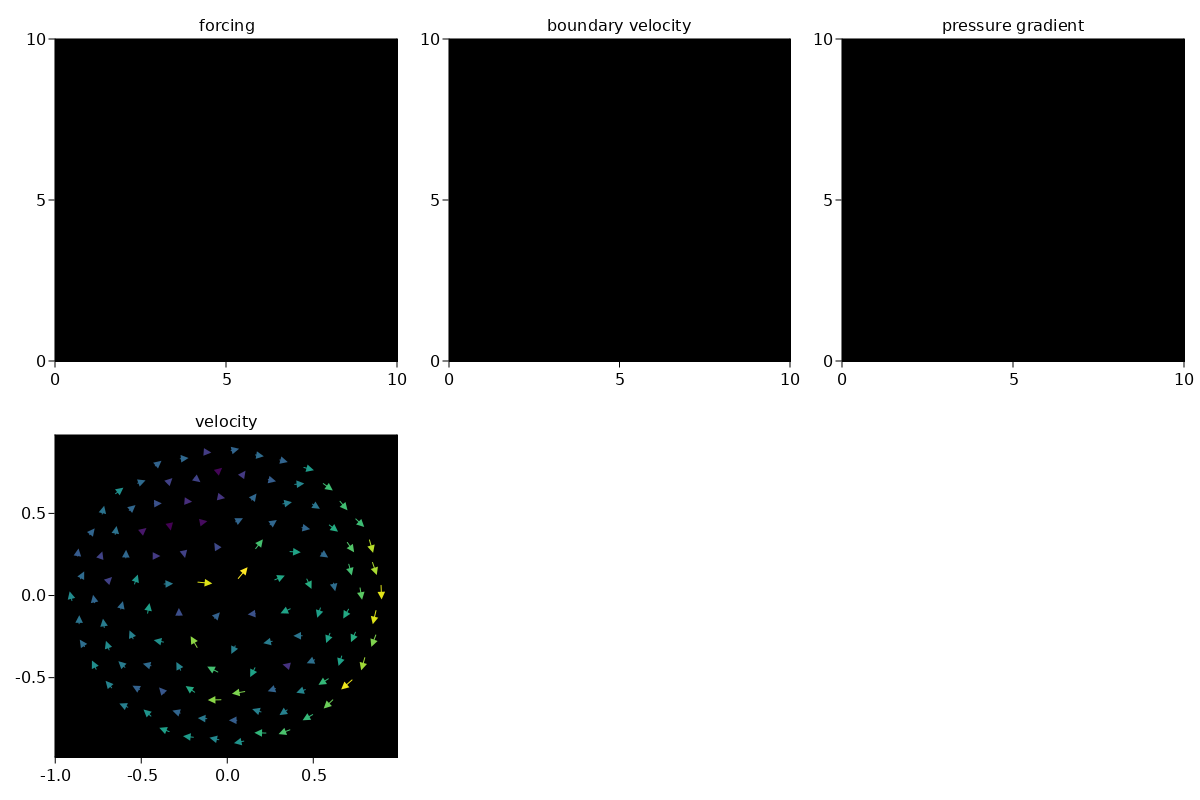

In [35]:
t_interest = 2
xsi = Internal_points[1,:]
ysi = Internal_points[2,:]

u = sol(t_interest)[1:N_i]
v = sol(t_interest)[N_i+1:end]

#usi = f(t_interest)[1:2:2*N_i]
#vsi = f(t_interest)[2:2:2*N_i]

#up = ∇p(t_interest)[1:2:2*N_i]
#vp = ∇p(t_interest)[2:2:2*N_i]

#xsb = Boundary_points[1,:]
#ysb = Boundary_points[2,:]
#usb = g(t_interest)[1:2:2*N_b]
#vsb = g(t_interest)[2:2:2*N_b]

#strengthi = (sqrt.( usi.^ 2 .+  vsi.^ 2) )
#strengthb = (sqrt.( usb.^ 2 .+  vsb.^ 2) )
#strengthp = (sqrt.( (up.+0.0).^ 2 .+  (vp .+0.0).^ 2) )
strengthsol = (sqrt.( (u.+0.0).^ 2 .+  (v .+0.0).^ 2) )

fig = Figure(resolution = (3*400, 2*400))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
ax1 = Axis(subfig1[1, 1], backgroundcolor = "black",title = "forcing")
ax2 = Axis(subfig2[1, 1], backgroundcolor = "black",title = "boundary velocity")
ax3 = Axis(subfig3[1, 1], backgroundcolor = "black",title = "pressure gradient")
ax4 = Axis(subfig4[1, 1], backgroundcolor = "black",title = "velocity")
#arrows!(ax1,xsi, ysi, usi, vsi, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthi, linecolor = strengthi) #,
#arrows!(ax2,xsb, ysb, usb, vsb, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthb, linecolor = strengthb) #,
#arrows!(ax3,xsi, ysi, up, vp, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp, linecolor = strengthp) #,
arrows!(ax4,xsi, ysi,u , v, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthsol, linecolor = strengthsol)
fig
#save("testingg.png",fig)

#println(up .^2 .+ vp .^2)

In [44]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift sol($time)[1:N_i] #- u_true($time)[1:N_i]
vs = @lift sol($time)[N_i+1:end]  #- u_true($time)[N_i+1:end] 
title = @lift string(round($time, digits=2))
strength2 = @lift sqrt.(sol($time+0.01)[1:N_i] .^ 2 .+ sol($time+0.01)[N_i+1:end] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.1, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2, step=1/framerate)
record(fig, "ODE_method.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"ODE_method.gif"

In [7]:
"""
# test the code on interpolation
M = construct_kernel_array(Φ_div,[λ₁,λ₂,λ₃],[λ₁,λ₂,λ₃])
O = compile_kernel_array(M)
int_points = hcat(generate_2D_equally_spaced_points(10)...)
tst_points, _ =  generate_2D_equally_spaced_points(20)
u₁_int = generate_vector_function(true_u₁,int_points)(1.3)
u₂_int = generate_vector_function(true_u₂,int_points)(1.3)
p_int = generate_vector_function(true_p,int_points)(1.3)

u₁_tst = generate_vector_function(true_u₁,tst_points)(1.3)
u₂_tst = generate_vector_function(true_u₂,tst_points)(1.3)
p_tst = generate_vector_function(true_p,tst_points)(1.3)


A_int = crete_block_point_tensors([int_points,int_points,int_points],[int_points,int_points,int_points])
A_tst = crete_block_point_tensors([tst_points,tst_points,tst_points],[int_points,int_points,int_points])
P_int = generate_block_matrices(O,A_int,2)
P_tst = generate_block_matrices(O,A_tst,2)
FF_int = flatten(P_int)
FF_tst = flatten(P_tst)

println("cond_number:", cond(FF_int))

reconstructed = FF_tst* (FF_int\ vcat(u₁_int,u₂_int,p_int))
error = reconstructed - vcat(u₁_tst,u₂_tst,p_tst)
fig, ax, hm = heatmap(tst_points[1,:],tst_points[2,:],error[324*2+1:324*3],aspect_ratio=:equal,colorbar=true)
Colorbar(fig[:, end+1], hm)
fig
"""

LoadError: syntax: invalid escape sequence